# Autoencoder Dimensionality Reduction

## 1. Introduction

Autoencoders are a class of neural networks designed for unsupervised representation learning. Their primary utility lies in learning a compressed, lower-dimensional representation (encoding) of input data, from which the original data can be approximately reconstructed.

### 1.1 Mathematical Foundation

An autoencoder consists of two components:

1. **Encoder** $f_{\phi}: \mathcal{X} \rightarrow \mathcal{Z}$ that maps input $\mathbf{x} \in \mathbb{R}^n$ to a latent representation $\mathbf{z} \in \mathbb{R}^d$ where $d < n$

2. **Decoder** $g_{\theta}: \mathcal{Z} \rightarrow \mathcal{X}$ that reconstructs $\hat{\mathbf{x}} \in \mathbb{R}^n$ from $\mathbf{z}$

The complete autoencoder function is:

$$\hat{\mathbf{x}} = g_{\theta}(f_{\phi}(\mathbf{x}))$$

### 1.2 Loss Function

The network is trained to minimize the reconstruction error:

$$\mathcal{L}(\mathbf{x}, \hat{\mathbf{x}}) = \|\mathbf{x} - \hat{\mathbf{x}}\|_2^2 = \sum_{i=1}^{n}(x_i - \hat{x}_i)^2$$

For a dataset $\{\mathbf{x}^{(1)}, \mathbf{x}^{(2)}, \ldots, \mathbf{x}^{(m)}\}$, the empirical risk is:

$$J(\phi, \theta) = \frac{1}{m}\sum_{j=1}^{m}\mathcal{L}(\mathbf{x}^{(j)}, g_{\theta}(f_{\phi}(\mathbf{x}^{(j)})))$$

### 1.3 Architecture

For a simple fully-connected autoencoder with one hidden layer, the encoder applies:

$$\mathbf{z} = \sigma(\mathbf{W}_e \mathbf{x} + \mathbf{b}_e)$$

where $\mathbf{W}_e \in \mathbb{R}^{d \times n}$, $\mathbf{b}_e \in \mathbb{R}^d$, and $\sigma$ is a nonlinear activation function (e.g., ReLU: $\sigma(z) = \max(0, z)$).

The decoder reconstructs:

$$\hat{\mathbf{x}} = \sigma(\mathbf{W}_d \mathbf{z} + \mathbf{b}_d)$$

where $\mathbf{W}_d \in \mathbb{R}^{n \times d}$ and $\mathbf{b}_d \in \mathbb{R}^n$.

### 1.4 Gradient Descent Update

Parameters are updated via backpropagation:

$$\phi \leftarrow \phi - \eta \nabla_{\phi} J(\phi, \theta)$$
$$\theta \leftarrow \theta - \eta \nabla_{\theta} J(\phi, \theta)$$

where $\eta$ is the learning rate.

## 2. Implementation

We will implement a simple autoencoder from scratch using only NumPy to demonstrate dimensionality reduction on synthetic data. This implementation uses mini-batch gradient descent with the Adam optimizer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

np.random.seed(42)

### 2.1 Generate Synthetic High-Dimensional Data

We generate data that lies on a 2D manifold embedded in 10D space. This simulates the common scenario where high-dimensional data has intrinsic low-dimensional structure.

In [2]:
def generate_manifold_data(n_samples=1000, n_features=10, intrinsic_dim=2, noise=0.1):
    """
    Generate data on a low-dimensional manifold in high-dimensional space.
    
    The data is generated by:
    1. Sampling points in intrinsic_dim dimensions
    2. Applying a random linear transformation to n_features dimensions
    3. Adding nonlinearity and noise
    """
    # Generate intrinsic coordinates (3 clusters)
    t = np.zeros((n_samples, intrinsic_dim))
    labels = np.zeros(n_samples, dtype=int)
    
    n_per_cluster = n_samples // 3
    centers = [[-2, -2], [2, -2], [0, 2]]
    
    for i, center in enumerate(centers):
        start_idx = i * n_per_cluster
        end_idx = start_idx + n_per_cluster if i < 2 else n_samples
        t[start_idx:end_idx] = np.random.randn(end_idx - start_idx, intrinsic_dim) * 0.5 + center
        labels[start_idx:end_idx] = i
    
    # Random projection matrix
    W = np.random.randn(intrinsic_dim, n_features) / np.sqrt(intrinsic_dim)
    
    # Nonlinear transformation with noise
    X = np.tanh(t @ W) + noise * np.random.randn(n_samples, n_features)
    
    return X, t, labels

# Generate data
X, t_true, labels = generate_manifold_data(n_samples=1500, n_features=10, intrinsic_dim=2)
print(f"Data shape: {X.shape}")
print(f"True intrinsic coordinates shape: {t_true.shape}")

Data shape: (1500, 10)
True intrinsic coordinates shape: (1500, 2)


### 2.2 Autoencoder Implementation

We implement a 3-layer autoencoder: Input → Hidden (encoding) → Output (reconstruction)

In [3]:
class Autoencoder:
    """
    Simple fully-connected autoencoder with one hidden (bottleneck) layer.
    Uses ReLU activation and Adam optimizer.
    """
    
    def __init__(self, input_dim, encoding_dim, hidden_dim=32):
        """
        Initialize autoencoder.
        
        Parameters:
        -----------
        input_dim : int
            Dimension of input data
        encoding_dim : int
            Dimension of the bottleneck (latent) layer
        hidden_dim : int
            Dimension of intermediate hidden layers
        """
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.hidden_dim = hidden_dim
        
        # Xavier initialization
        self.W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros((1, hidden_dim))
        
        self.W2 = np.random.randn(hidden_dim, encoding_dim) * np.sqrt(2.0 / hidden_dim)
        self.b2 = np.zeros((1, encoding_dim))
        
        self.W3 = np.random.randn(encoding_dim, hidden_dim) * np.sqrt(2.0 / encoding_dim)
        self.b3 = np.zeros((1, hidden_dim))
        
        self.W4 = np.random.randn(hidden_dim, input_dim) * np.sqrt(2.0 / hidden_dim)
        self.b4 = np.zeros((1, input_dim))
        
        # Adam optimizer parameters
        self.m = {}
        self.v = {}
        self.t = 0
        for name in ['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4']:
            self.m[name] = np.zeros_like(getattr(self, name))
            self.v[name] = np.zeros_like(getattr(self, name))
    
    def relu(self, x):
        """ReLU activation: max(0, x)"""
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        """Derivative of ReLU"""
        return (x > 0).astype(float)
    
    def encode(self, X):
        """Encode input to latent representation."""
        h1 = self.relu(X @ self.W1 + self.b1)
        z = X @ self.W1 + self.b1
        h1 = self.relu(z)
        z2 = h1 @ self.W2 + self.b2
        return z2  # Linear encoding layer
    
    def decode(self, z):
        """Decode latent representation to reconstruction."""
        h3 = self.relu(z @ self.W3 + self.b3)
        x_hat = h3 @ self.W4 + self.b4  # Linear output
        return x_hat
    
    def forward(self, X):
        """Forward pass through the autoencoder."""
        # Encoder
        self.z1 = X @ self.W1 + self.b1
        self.h1 = self.relu(self.z1)
        self.z2 = self.h1 @ self.W2 + self.b2  # Encoding (linear)
        
        # Decoder
        self.z3 = self.z2 @ self.W3 + self.b3
        self.h3 = self.relu(self.z3)
        self.z4 = self.h3 @ self.W4 + self.b4  # Reconstruction (linear)
        
        return self.z4
    
    def backward(self, X, X_hat):
        """Compute gradients via backpropagation."""
        m = X.shape[0]
        
        # Output layer gradient (MSE loss derivative)
        dz4 = (X_hat - X) / m
        
        self.dW4 = self.h3.T @ dz4
        self.db4 = np.sum(dz4, axis=0, keepdims=True)
        
        # Hidden layer 3
        dh3 = dz4 @ self.W4.T
        dz3 = dh3 * self.relu_derivative(self.z3)
        
        self.dW3 = self.z2.T @ dz3
        self.db3 = np.sum(dz3, axis=0, keepdims=True)
        
        # Encoding layer (linear, so no activation derivative)
        dz2 = dz3 @ self.W3.T
        
        self.dW2 = self.h1.T @ dz2
        self.db2 = np.sum(dz2, axis=0, keepdims=True)
        
        # Hidden layer 1
        dh1 = dz2 @ self.W2.T
        dz1 = dh1 * self.relu_derivative(self.z1)
        
        self.dW1 = X.T @ dz1
        self.db1 = np.sum(dz1, axis=0, keepdims=True)
    
    def adam_update(self, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        """Update weights using Adam optimizer."""
        self.t += 1
        
        for name in ['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4']:
            grad = getattr(self, 'd' + name)
            
            # Update biased first moment estimate
            self.m[name] = beta1 * self.m[name] + (1 - beta1) * grad
            # Update biased second raw moment estimate
            self.v[name] = beta2 * self.v[name] + (1 - beta2) * (grad ** 2)
            
            # Bias correction
            m_hat = self.m[name] / (1 - beta1 ** self.t)
            v_hat = self.v[name] / (1 - beta2 ** self.t)
            
            # Update parameters
            param = getattr(self, name)
            param -= lr * m_hat / (np.sqrt(v_hat) + eps)
            setattr(self, name, param)
    
    def fit(self, X, epochs=200, batch_size=64, lr=0.001, verbose=True):
        """Train the autoencoder."""
        n_samples = X.shape[0]
        losses = []
        
        for epoch in range(epochs):
            # Shuffle data
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            
            epoch_loss = 0
            n_batches = 0
            
            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                
                # Forward pass
                X_hat = self.forward(X_batch)
                
                # Compute loss
                loss = np.mean((X_batch - X_hat) ** 2)
                epoch_loss += loss
                n_batches += 1
                
                # Backward pass
                self.backward(X_batch, X_hat)
                
                # Update weights
                self.adam_update(lr=lr)
            
            avg_loss = epoch_loss / n_batches
            losses.append(avg_loss)
            
            if verbose and (epoch + 1) % 20 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")
        
        return losses

### 2.3 Data Preprocessing

Standardize the data to have zero mean and unit variance for stable training.

In [4]:
# Standardize data
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_normalized = (X - X_mean) / (X_std + 1e-8)

# Split into train and test
n_train = int(0.8 * len(X_normalized))
indices = np.random.permutation(len(X_normalized))
train_idx, test_idx = indices[:n_train], indices[n_train:]

X_train = X_normalized[train_idx]
X_test = X_normalized[test_idx]
labels_train = labels[train_idx]
labels_test = labels[test_idx]
t_true_test = t_true[test_idx]

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

Training samples: 1200
Test samples: 300


### 2.4 Train the Autoencoder

In [5]:
# Initialize and train autoencoder
ae = Autoencoder(input_dim=10, encoding_dim=2, hidden_dim=32)
losses = ae.fit(X_train, epochs=200, batch_size=64, lr=0.005, verbose=True)

Epoch 20/200, Loss: 0.030677
Epoch 40/200, Loss: 0.021216


Epoch 60/200, Loss: 0.017985
Epoch 80/200, Loss: 0.016453
Epoch 100/200, Loss: 0.015964


Epoch 120/200, Loss: 0.015334
Epoch 140/200, Loss: 0.015302
Epoch 160/200, Loss: 0.014922


Epoch 180/200, Loss: 0.014836
Epoch 200/200, Loss: 0.014502


### 2.5 Evaluate Reconstruction Quality

In [6]:
# Compute test reconstruction error
X_test_reconstructed = ae.forward(X_test)
test_mse = np.mean((X_test - X_test_reconstructed) ** 2)
print(f"Test MSE: {test_mse:.6f}")

# Compute variance explained
total_variance = np.var(X_test)
residual_variance = np.var(X_test - X_test_reconstructed)
variance_explained = 1 - (residual_variance / total_variance)
print(f"Variance explained: {variance_explained:.2%}")

Test MSE: 0.015341
Variance explained: 98.46%


## 3. Visualization and Analysis

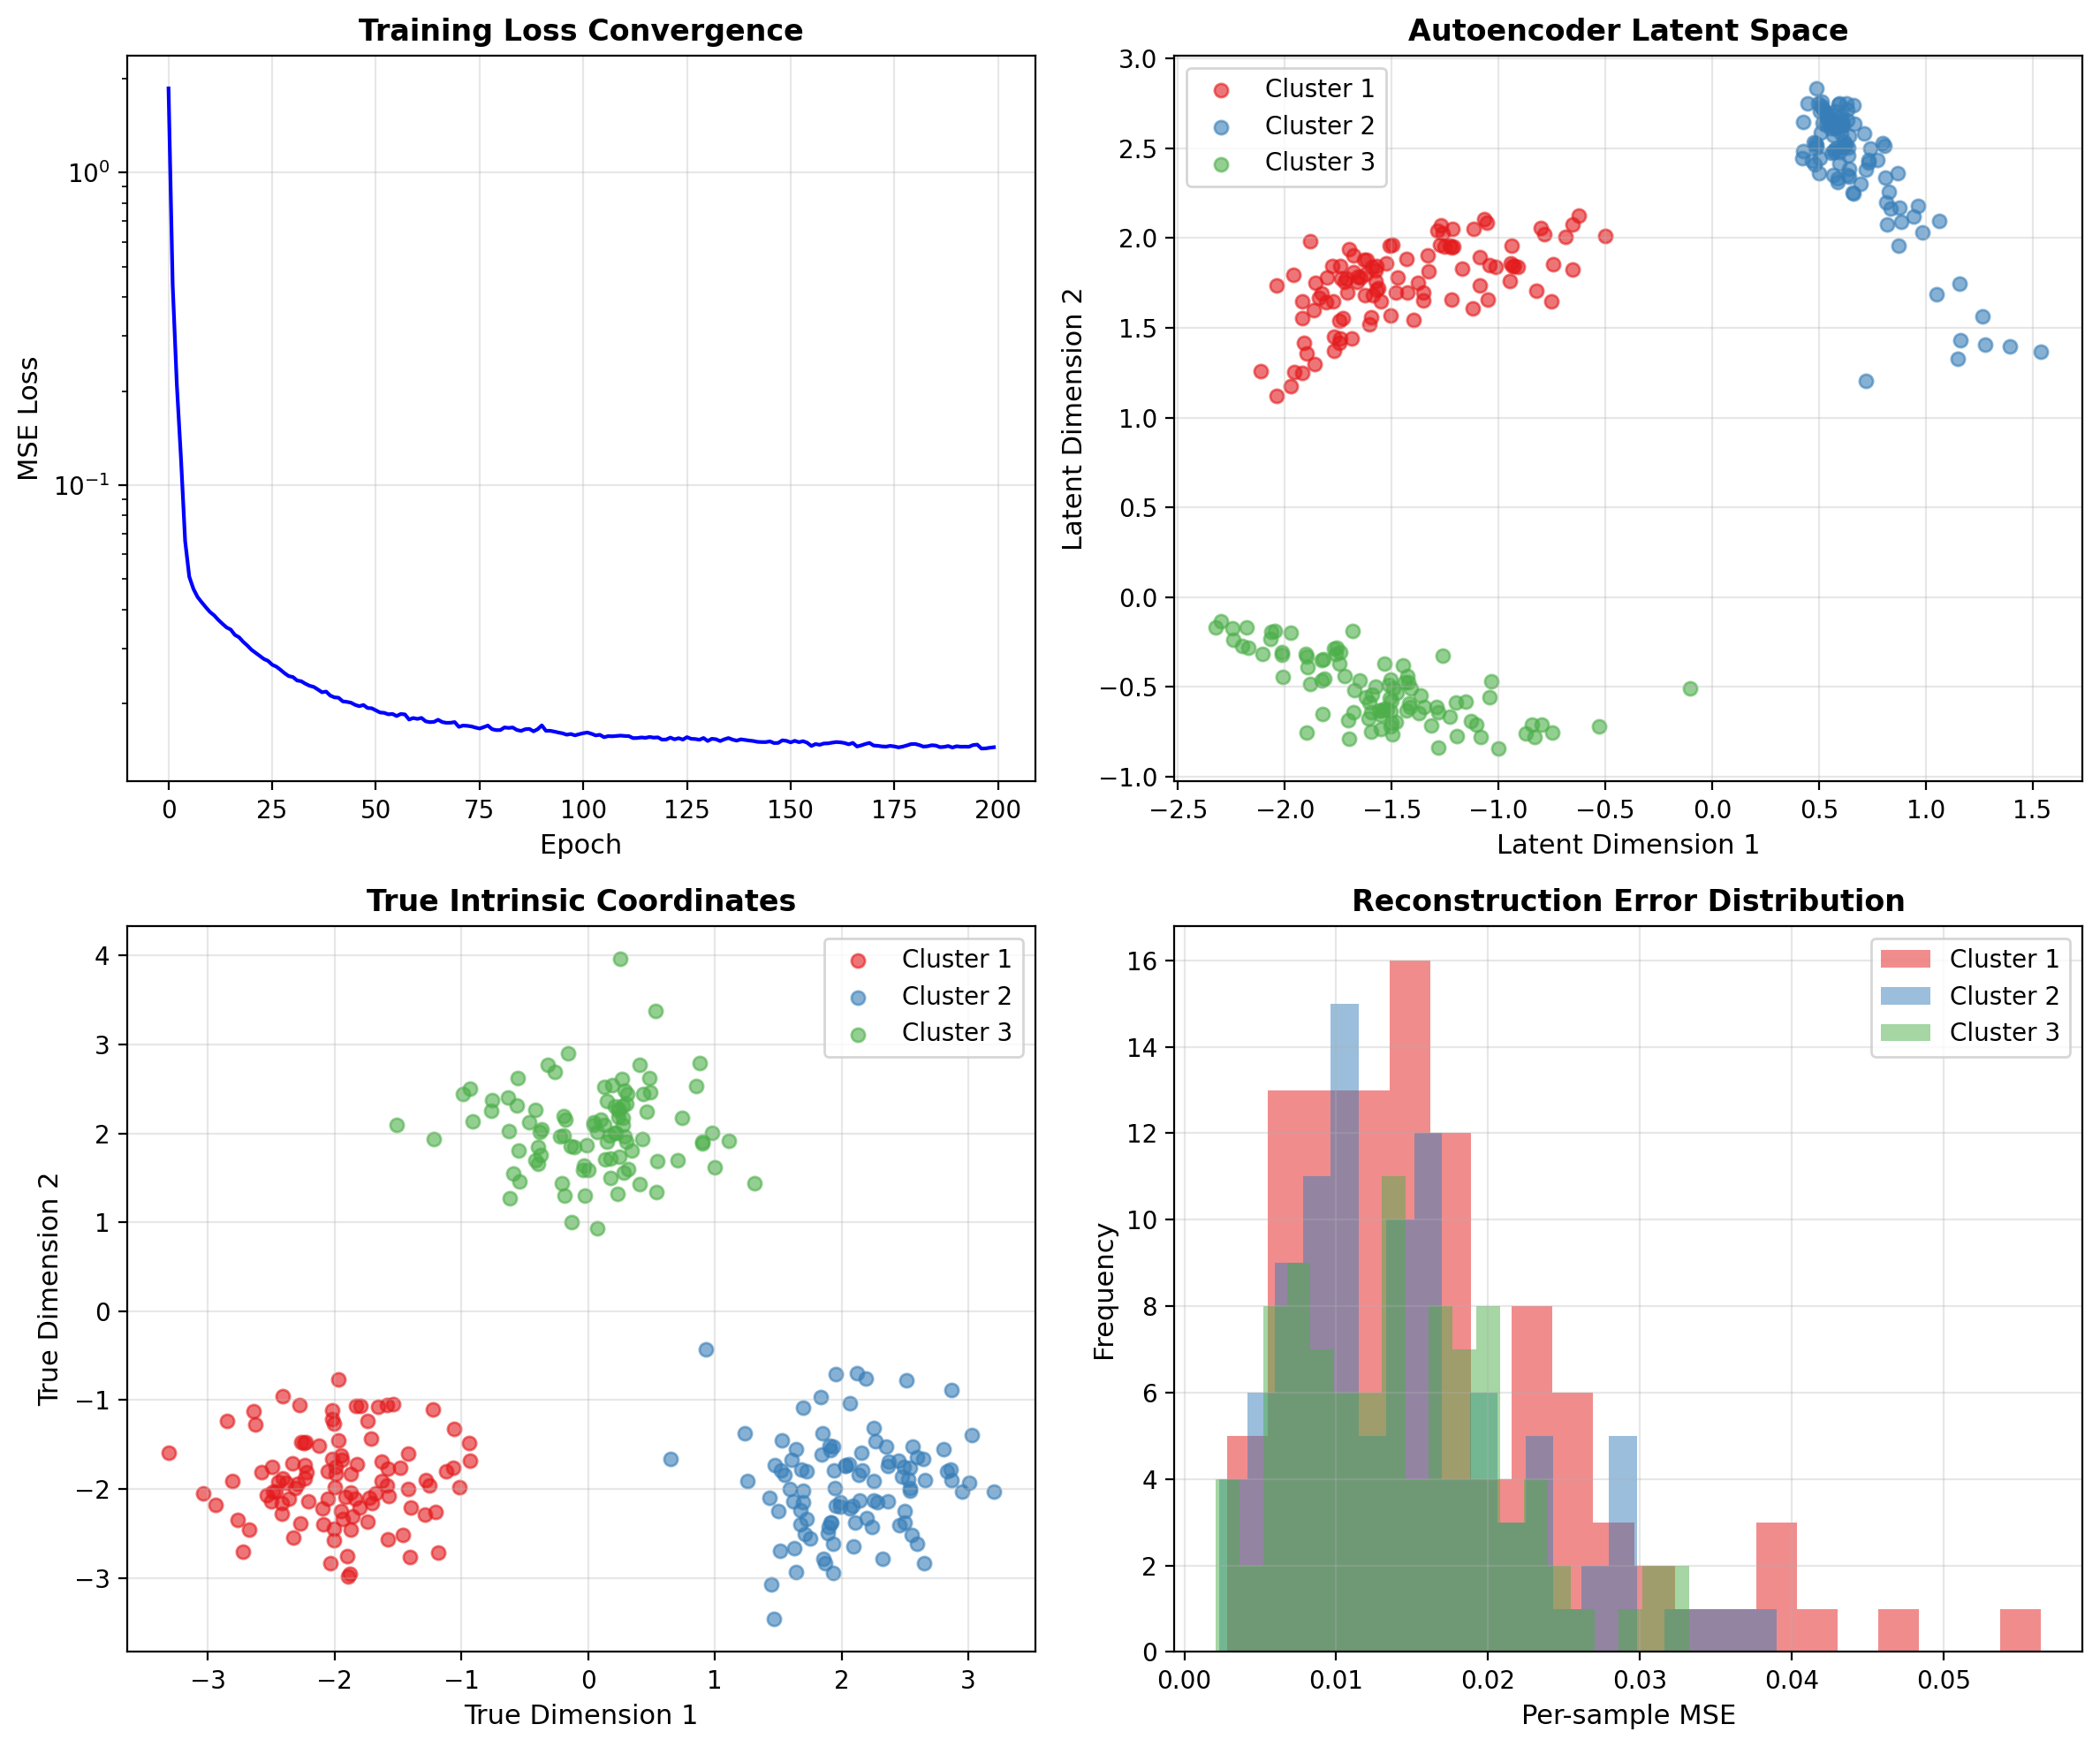


Plot saved to 'plot.png'


In [7]:
# Get encodings for test data
encodings = ae.encode(X_test)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Training loss curve
ax1 = axes[0, 0]
ax1.plot(losses, 'b-', linewidth=1.5)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('MSE Loss', fontsize=11)
ax1.set_title('Training Loss Convergence', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Learned latent space (2D encodings)
ax2 = axes[0, 1]
colors = ['#e41a1c', '#377eb8', '#4daf4a']
for i in range(3):
    mask = labels_test == i
    ax2.scatter(encodings[mask, 0], encodings[mask, 1], 
                c=colors[i], label=f'Cluster {i+1}', alpha=0.6, s=30)
ax2.set_xlabel('Latent Dimension 1', fontsize=11)
ax2.set_ylabel('Latent Dimension 2', fontsize=11)
ax2.set_title('Autoencoder Latent Space', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: True intrinsic coordinates for comparison
ax3 = axes[1, 0]
for i in range(3):
    mask = labels_test == i
    ax3.scatter(t_true_test[mask, 0], t_true_test[mask, 1], 
                c=colors[i], label=f'Cluster {i+1}', alpha=0.6, s=30)
ax3.set_xlabel('True Dimension 1', fontsize=11)
ax3.set_ylabel('True Dimension 2', fontsize=11)
ax3.set_title('True Intrinsic Coordinates', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Reconstruction error distribution
ax4 = axes[1, 1]
reconstruction_errors = np.mean((X_test - X_test_reconstructed) ** 2, axis=1)
for i in range(3):
    mask = labels_test == i
    ax4.hist(reconstruction_errors[mask], bins=20, alpha=0.5, 
             color=colors[i], label=f'Cluster {i+1}')
ax4.set_xlabel('Per-sample MSE', fontsize=11)
ax4.set_ylabel('Frequency', fontsize=11)
ax4.set_title('Reconstruction Error Distribution', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('autoencoder_dimensionality_reduction_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## 4. Comparison with PCA

We compare the autoencoder's learned representation with Principal Component Analysis (PCA), a classical linear dimensionality reduction technique.

In [8]:
def pca(X, n_components):
    """
    Principal Component Analysis implementation.
    
    PCA finds the directions of maximum variance:
    1. Center the data
    2. Compute covariance matrix: C = (1/n) X^T X
    3. Eigendecomposition: C = V Λ V^T
    4. Project onto top k eigenvectors
    """
    # Center the data
    X_centered = X - X.mean(axis=0)
    
    # Compute covariance matrix
    cov_matrix = np.cov(X_centered.T)
    
    # Eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Sort by eigenvalue (descending)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Select top components
    components = eigenvectors[:, :n_components]
    
    # Project data
    X_pca = X_centered @ components
    
    # Variance explained
    var_explained = eigenvalues[:n_components] / eigenvalues.sum()
    
    return X_pca, var_explained, components

# Apply PCA
X_test_pca, pca_var_explained, pca_components = pca(X_test, n_components=2)

print(f"PCA variance explained by first 2 components: {pca_var_explained.sum():.2%}")
print(f"  - PC1: {pca_var_explained[0]:.2%}")
print(f"  - PC2: {pca_var_explained[1]:.2%}")

PCA variance explained by first 2 components: 96.78%
  - PC1: 73.68%
  - PC2: 23.10%


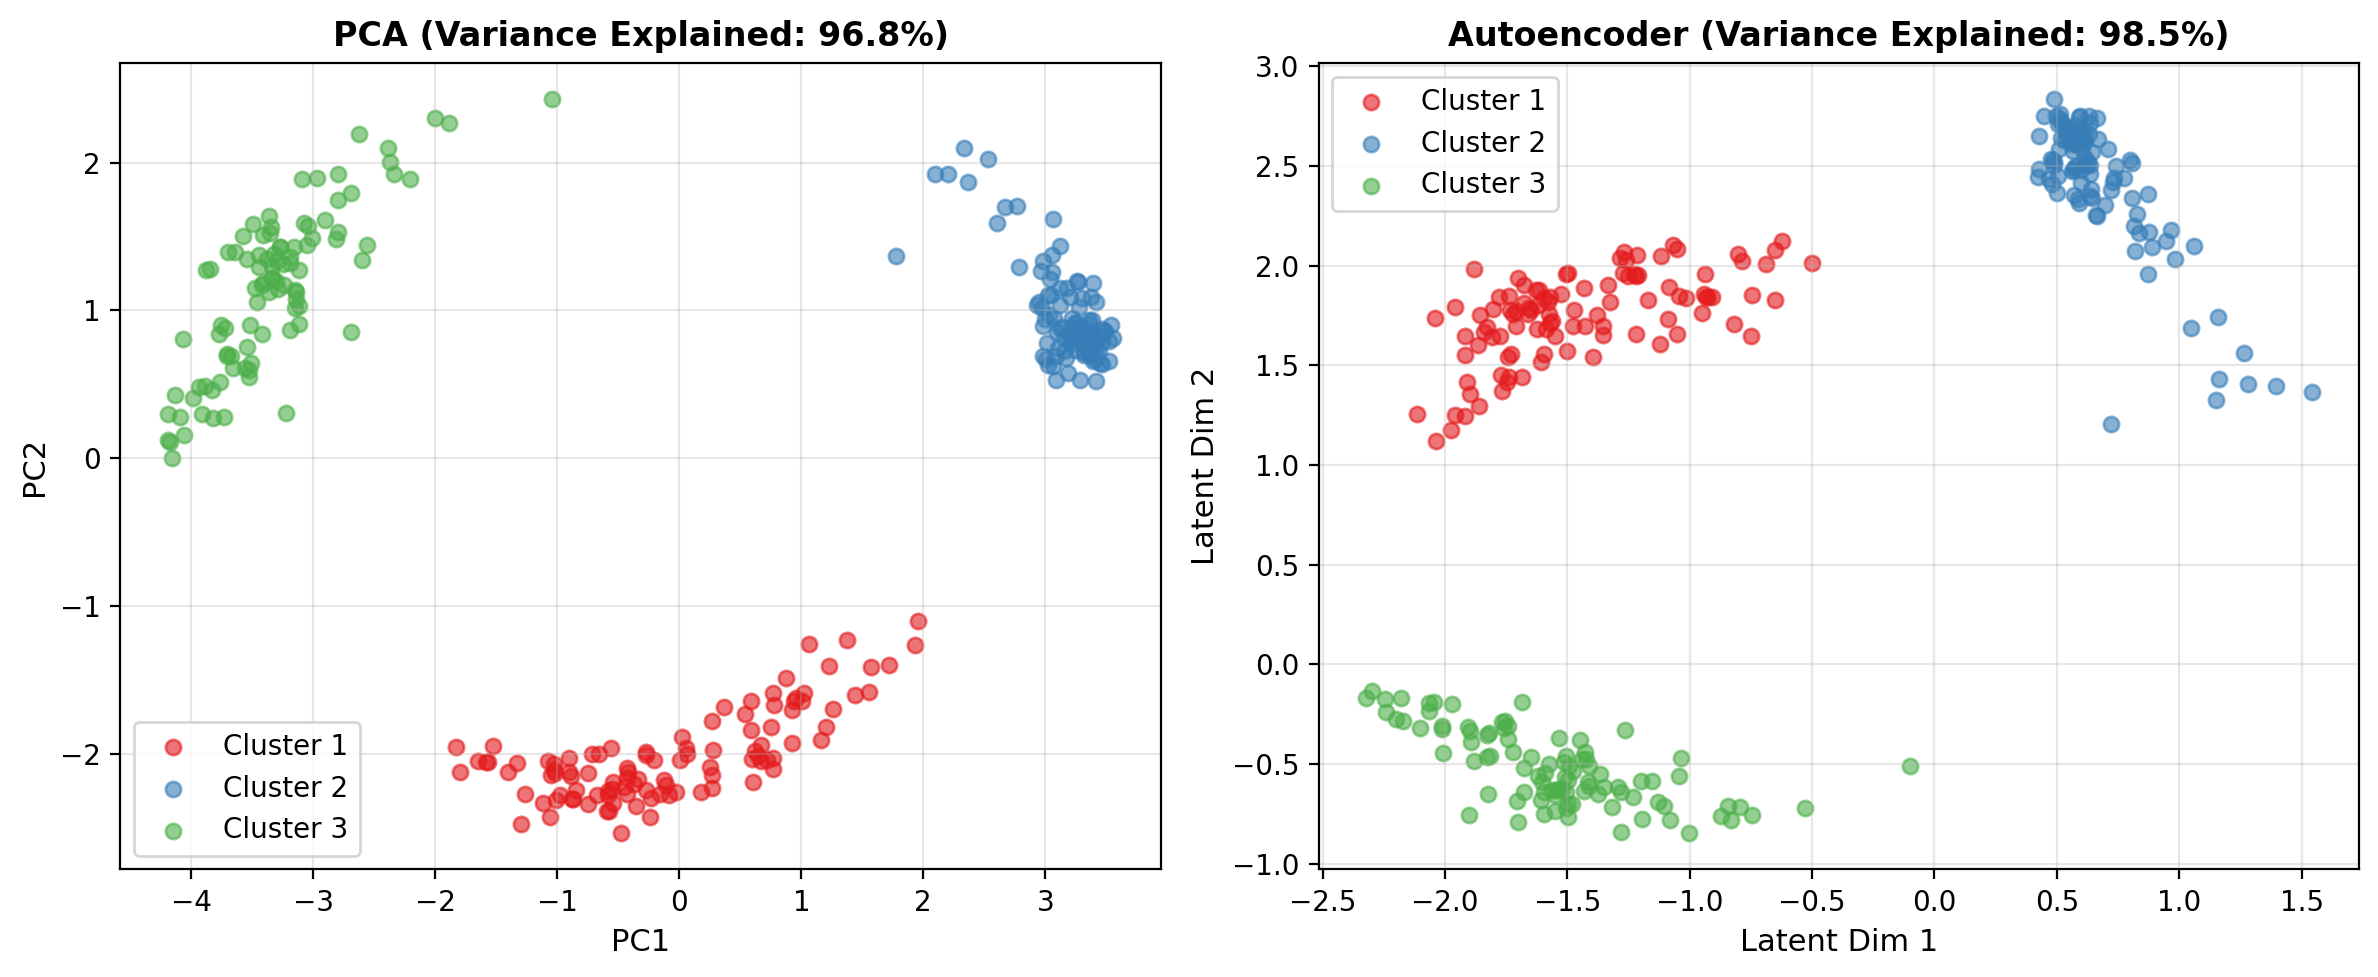

In [9]:
# Compare PCA vs Autoencoder
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# PCA projection
ax1 = axes[0]
for i in range(3):
    mask = labels_test == i
    ax1.scatter(X_test_pca[mask, 0], X_test_pca[mask, 1], 
                c=colors[i], label=f'Cluster {i+1}', alpha=0.6, s=30)
ax1.set_xlabel('PC1', fontsize=11)
ax1.set_ylabel('PC2', fontsize=11)
ax1.set_title(f'PCA (Variance Explained: {pca_var_explained.sum():.1%})', 
              fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Autoencoder projection
ax2 = axes[1]
for i in range(3):
    mask = labels_test == i
    ax2.scatter(encodings[mask, 0], encodings[mask, 1], 
                c=colors[i], label=f'Cluster {i+1}', alpha=0.6, s=30)
ax2.set_xlabel('Latent Dim 1', fontsize=11)
ax2.set_ylabel('Latent Dim 2', fontsize=11)
ax2.set_title(f'Autoencoder (Variance Explained: {variance_explained:.1%})', 
              fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Conclusions

This notebook demonstrated:

1. **Autoencoder Architecture**: A neural network with encoder $f_{\phi}$ and decoder $g_{\theta}$ that learns compressed representations by minimizing reconstruction error $\|\mathbf{x} - g_{\theta}(f_{\phi}(\mathbf{x}))\|_2^2$.

2. **Nonlinear Dimensionality Reduction**: Unlike PCA which finds linear projections, autoencoders can capture nonlinear manifold structure through their nonlinear activation functions.

3. **Cluster Preservation**: The 2D latent space preserves the cluster structure present in the original 10D data, demonstrating effective dimensionality reduction.

4. **Comparison with PCA**: Both methods reduce dimensionality, but autoencoders can potentially capture more complex relationships due to their nonlinearity.

### Key Equations Summary

- **Encoder**: $\mathbf{z} = f_{\phi}(\mathbf{x})$
- **Decoder**: $\hat{\mathbf{x}} = g_{\theta}(\mathbf{z})$  
- **Loss**: $\mathcal{L} = \frac{1}{m}\sum_{i=1}^{m}\|\mathbf{x}^{(i)} - \hat{\mathbf{x}}^{(i)}\|_2^2$
- **Adam Update**: $\theta \leftarrow \theta - \eta \cdot \hat{m}_t / (\sqrt{\hat{v}_t} + \epsilon)$